In [1]:
import os
import json
import math
import numpy as np
import pandas as pd

## Imports for plotting
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import set_matplotlib_formats
# set_matplotlib_formats('svg', 'pdf') # For export
from matplotlib.colors import to_rgb
import matplotlib
matplotlib.rcParams['lines.linewidth'] = 2.0
import seaborn as sns
sns.reset_orig()
sns.set()


## PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim
# Torchvision
import torchvision
from torchvision.utils import save_image
from torchvision.datasets import FashionMNIST
from torchvision.transforms import v2
from torchvision.datasets import ImageFolder
from torch.nn.functional import one_hot

from pytorch_fid import fid_score

/usr/local/lib/python3.10/dist-packages/torchvision/datapoints/__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/__init__.py:54: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https:/

In [2]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print("Device:", device)

Device: cuda


In [3]:
transform = v2.Compose(
    [
     v2.ToTensor(),
     #v2.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])

train_data = ImageFolder('./trafic_32', transform=transform)
train_classes = train_data.classes
train_classes = [name.lstrip('0') if name != '00000' else '0' for name in train_classes]

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `transforms.Compose([transforms.ToImageTensor(), transforms.ConvertImageDtype()])`.
  warnings.warn(


In [4]:
train_loader = data.DataLoader(train_data, batch_size=256, shuffle=True, drop_last=True, pin_memory=True, num_workers=4)

In [5]:
data, classes = next(iter(train_loader))
# data.size()


## VAE

In [6]:
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim1, hidden_dim2, latent_dim, last_dim):
        super(Encoder, self).__init__()

        self.fc_1 = nn.Linear(input_dim, hidden_dim1)
        self.hid1 = [nn.Linear(hidden_dim1, hidden_dim1) for i in range(5)]
  

        self.fc_2 = nn.Linear(hidden_dim1, hidden_dim2)
        self.hid2 = [nn.Linear(hidden_dim2, hidden_dim2) for i in range(5)]
      
        self.fc_3= nn.Linear(hidden_dim2, last_dim)
        self.last = [nn.Linear(last_dim, last_dim) for i in range(5)]


        self.fc_mean  = nn.Linear(last_dim, latent_dim)
        self.fc_var   = nn.Linear (last_dim, latent_dim)

        self.LeakyReLU = nn.LeakyReLU(0.2)

        self.training = True

    def forward(self, x):
        x = torch.flatten(x, 1)
        x = self.LeakyReLU(self.fc_1(x))
        for i in range(5):
            x = self.LeakyReLU(self.hid1[i](x))
        x = self.LeakyReLU(self.fc_2(x))
        
        for i in range(5):
            x = self.LeakyReLU(self.hid2[i](x))
        x = self.LeakyReLU(self.fc_3(x))
        
        for i in range(5):
            x = self.LeakyReLU(self.last[i](x))
        
        mean     = self.fc_mean(x)
        log_var  = self.fc_var(x)                      # encoder produces mean and log of variance
                                                       #             (i.e., parateters of simple tractable normal distribution "q"

        return mean, log_var

In [7]:
class Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim1, hidden_dim2, output_dim, last_dim):
        super(Decoder, self).__init__()
        self.fc_1 = nn.Linear(latent_dim, last_dim)
        self.last = [nn.Linear(last_dim, last_dim) for i in range(5)]
  

        self.fc_2 = nn.Linear(last_dim, hidden_dim2)
        self.hid2 = [nn.Linear(hidden_dim2, hidden_dim2) for i in range(5)]
      
        self.fc_3= nn.Linear(hidden_dim2, hidden_dim1)
        self.hid1 = [nn.Linear(hidden_dim1, hidden_dim1) for i in range(5)]
        self.fc_4= nn.Linear(hidden_dim1, output_dim)


        self.LeakyReLU = nn.LeakyReLU(0.2)

    def forward(self, x):
        x = self.LeakyReLU(self.fc_1(x))
        for i in range(5):
            x = self.LeakyReLU(self.last[i](x))
        x = self.LeakyReLU(self.fc_2(x))
        
        for i in range(5):
            x = self.LeakyReLU(self.hid2[i](x))
        x = self.LeakyReLU(self.fc_3(x))
        
        for i in range(5):
            x = self.LeakyReLU(self.hid1[i](x))

        x_hat = torch.sigmoid(self.fc_4(x))
        x_hat = x_hat.view([-1, 3, 32, 32])
        return x_hat

In [8]:
class VAE(nn.Module):
    def __init__(self, x_dim, hidden_dim1, hidden_dim2, latent_dim, last_dim):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim
        self.encoder = Encoder(input_dim=x_dim, hidden_dim1=hidden_dim1, latent_dim=latent_dim, last_dim=last_dim, hidden_dim2=hidden_dim2)
        self.decoder = Decoder(latent_dim=latent_dim+43, hidden_dim1 = hidden_dim1, output_dim = x_dim, last_dim=last_dim, hidden_dim2=hidden_dim2)


    def reparameterization(self, mean, var):
        z = torch.rand(1).to(device) * var + mean
        return z


    def forward(self, x, one_hot_class):
        mean, log_var = self.encoder(x)
        z = self.reparameterization(mean, torch.exp(0.5 * log_var)) # takes exponential function (log var -> var)
        z = torch.concat((z, one_hot_class), dim=1)

        x_hat = self.decoder(z)
        return x_hat, mean, log_var


## Training

In [9]:
vae = VAE(latent_dim=32, hidden_dim1=1024, x_dim=3072, last_dim=124, hidden_dim2=512).to(device)
for layer in vae.encoder.hid1:
    layer.to(device)
for layer in vae.encoder.hid2:
    layer.to(device)
for layer in vae.encoder.last:
    layer.to(device)
for layer in vae.decoder.hid1:
    layer.to(device)
for layer in vae.decoder.hid2:
    layer.to(device)
for layer in vae.decoder.last:
    layer.to(device)

In [10]:
encoding = one_hot(torch.arange(0, 43), 43)

In [11]:
def get_classes_encoded(train_classes: list, classes_names: list, encoding):
    return torch.stack([encoding[train_classes.index(str(name.item()))] for name in classes_names], dim=0)

In [12]:
optimizer = optim.Adam(vae.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=0.99)

In [13]:
def vae_loss_function(x, x_hat, mean, log_var):
    reproduction_loss = nn.functional.mse_loss(x_hat, x, reduction='sum')
    KLD      = -0.5 * torch.sum(1+ log_var - mean.pow(2) - log_var.exp())

    return reproduction_loss + KLD

Epoch 0 loss 42395.881804023695


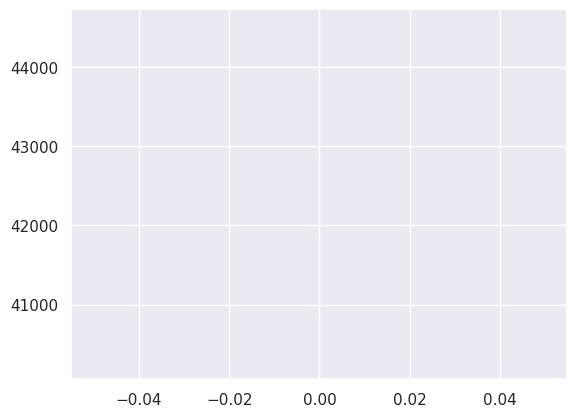

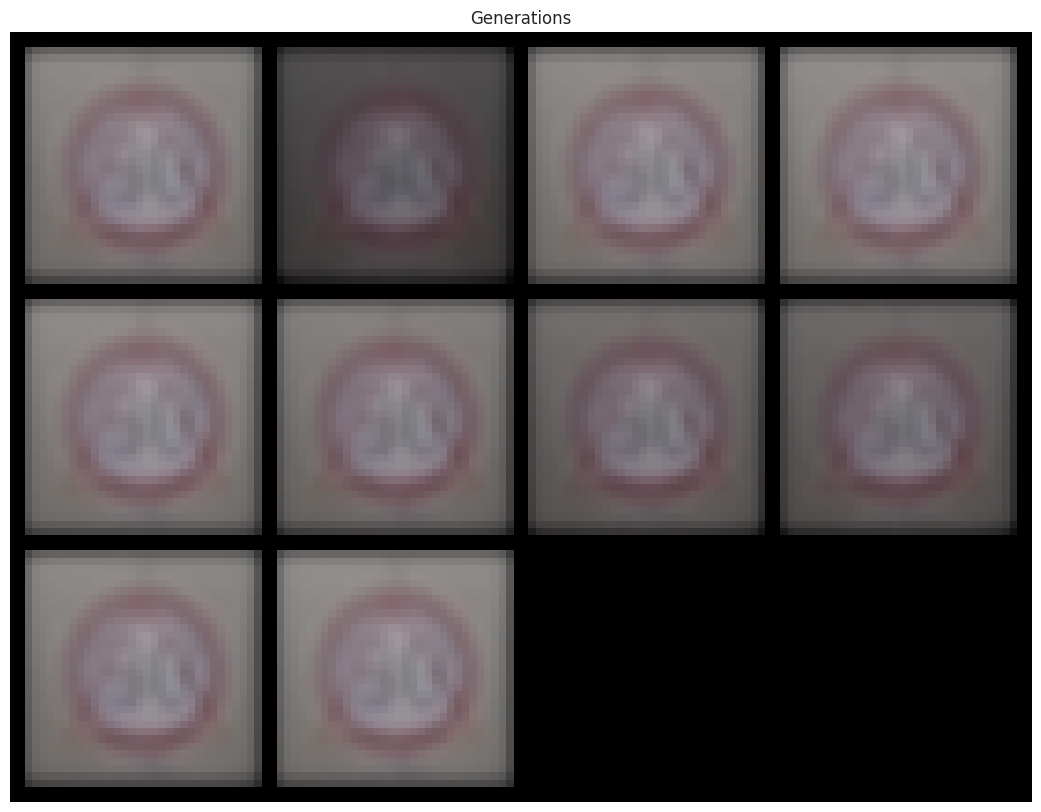

Epoch 1 loss 37580.00914011438
Epoch 2 loss 36558.864915236925
Epoch 3 loss 35383.487821691175
Epoch 4 loss 35917.153479881534
Epoch 5 loss 34491.59267769608
Epoch 6 loss 34089.08814593546
Epoch 7 loss 33860.889820772056
Epoch 8 loss 33008.119664011436
Epoch 9 loss 32559.93802338644
Epoch 10 loss 32054.79967064951
Epoch 11 loss 31352.494906556374
Epoch 12 loss 30750.58607792075
Epoch 13 loss 30452.27684589461
Epoch 14 loss 30285.641339869282
Epoch 15 loss 30157.50342116013
Epoch 16 loss 30019.54439848856
Epoch 17 loss 29740.19385723039
Epoch 18 loss 27606.058185253267
Epoch 19 loss 26222.59280535131
Epoch 20 loss 25890.17218137255
Epoch 21 loss 25728.439912683825
Epoch 22 loss 25398.73598345588
Epoch 23 loss 25299.361404718136
Epoch 24 loss 25135.51220383987
Epoch 25 loss 24866.238357843136
Epoch 26 loss 24955.25469771242
Epoch 27 loss 24561.67236008987
Epoch 28 loss 24099.43035130719
Epoch 29 loss 23626.071193321077
Epoch 30 loss 23221.49103860294
Epoch 31 loss 23037.217230902777
Epoc

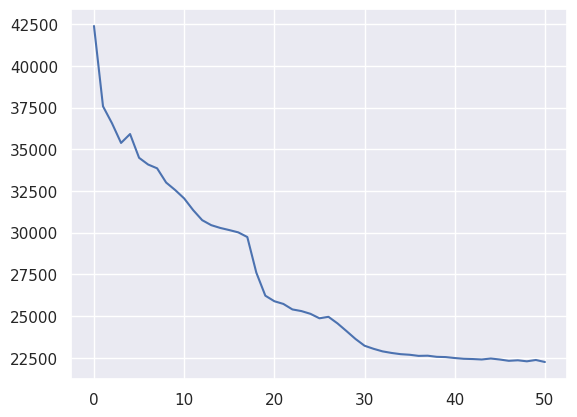

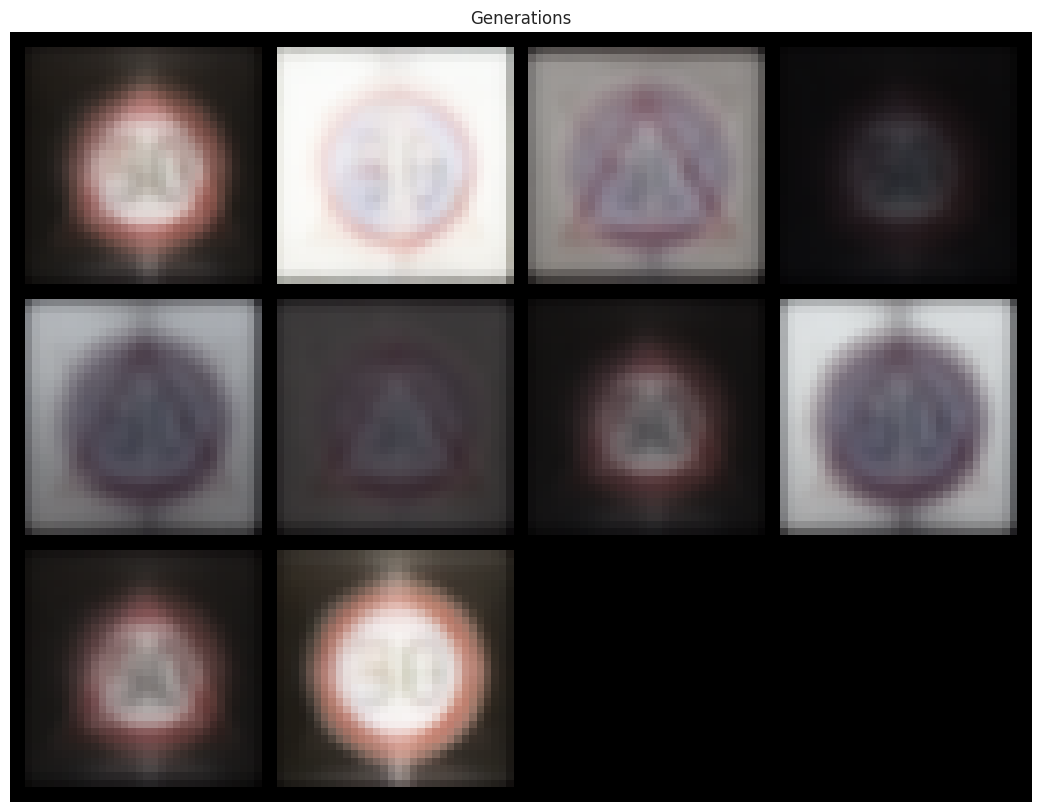

Epoch 51 loss 22214.877374387255
Epoch 52 loss 22203.13996119281
Epoch 53 loss 22182.106349571077
Epoch 54 loss 22180.420215482027
Epoch 55 loss 22144.442976409315
Epoch 56 loss 22120.613166360294
Epoch 57 loss 22097.346137152777
Epoch 58 loss 22086.876697814543
Epoch 59 loss 22107.369255514706
Epoch 60 loss 22066.055568321077
Epoch 61 loss 22025.441801981207
Epoch 62 loss 21981.318346609478
Epoch 63 loss 21963.585516237745
Epoch 64 loss 21930.03026705474
Epoch 65 loss 21902.6968188317
Epoch 66 loss 21889.555376838234
Epoch 67 loss 21859.54181985294
Epoch 68 loss 21859.50612745098
Epoch 69 loss 21792.09157986111
Epoch 70 loss 21773.682010825163
Epoch 71 loss 21767.12157883987
Epoch 72 loss 21707.299874897875
Epoch 73 loss 21690.48096660539
Epoch 74 loss 21650.19389552696
Epoch 75 loss 21626.433785232843
Epoch 76 loss 21609.52047589869
Epoch 77 loss 21575.83464818219
Epoch 78 loss 21530.840124591505
Epoch 79 loss 21540.74075776144
Epoch 80 loss 21512.293338950163
Epoch 81 loss 21441.341

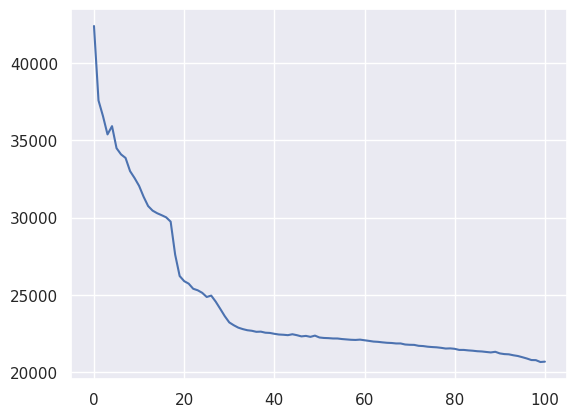

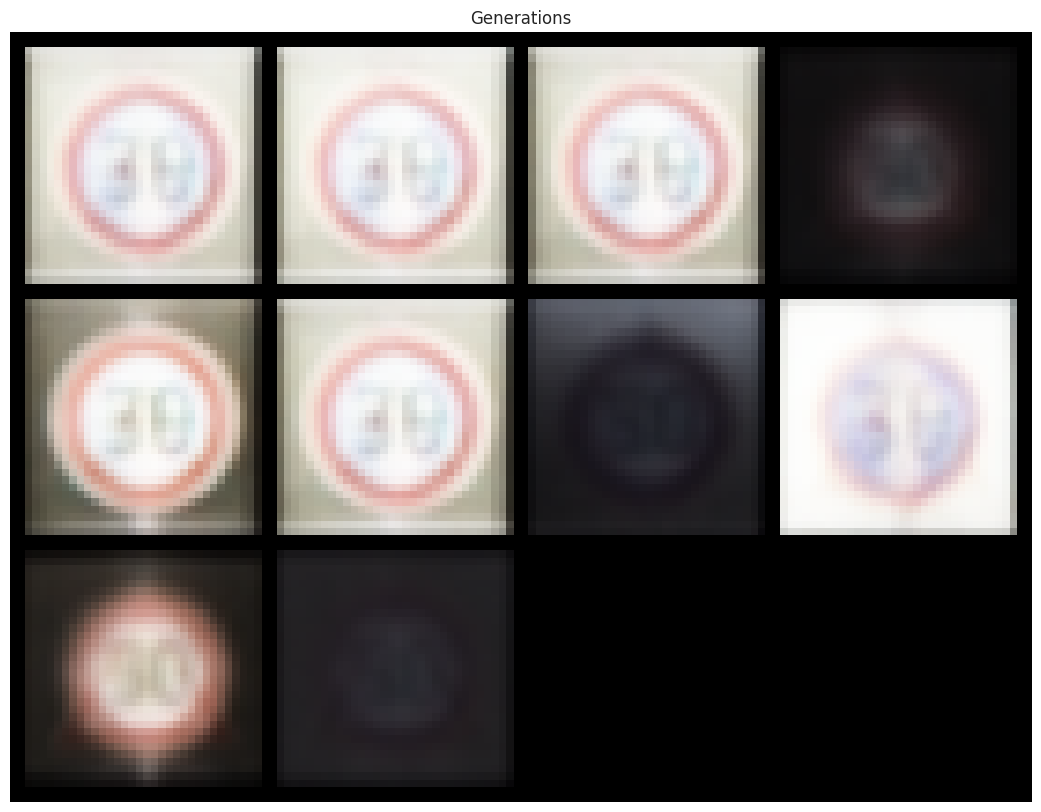

Epoch 101 loss 20623.34192453023
Epoch 102 loss 20549.73699193219
Epoch 103 loss 20500.160807291668
Epoch 104 loss 20458.14635671977
Epoch 105 loss 20406.490885416668
Epoch 106 loss 20429.79323682598
Epoch 107 loss 20359.312474468956
Epoch 108 loss 20399.4392871732
Epoch 109 loss 20308.859451593136
Epoch 110 loss 20305.608379289217
Epoch 111 loss 20254.96860957925
Epoch 112 loss 20238.61453227124
Epoch 113 loss 20202.880935968136
Epoch 114 loss 20182.95382710376
Epoch 115 loss 20140.56152982026
Epoch 116 loss 20118.59339256536
Epoch 117 loss 20099.09472017974
Epoch 118 loss 20049.03484987745
Epoch 119 loss 20044.178334354576
Epoch 120 loss 20037.93065767974
Epoch 121 loss 19990.72252859477
Epoch 122 loss 19917.261003880718
Epoch 123 loss 19863.933491625816
Epoch 124 loss 19784.604409211603
Epoch 125 loss 19659.42955984477
Epoch 126 loss 19591.221922232435
Epoch 127 loss 19535.64582056781
Epoch 128 loss 19449.197859221815
Epoch 129 loss 19381.755565767973
Epoch 130 loss 19346.0400709763

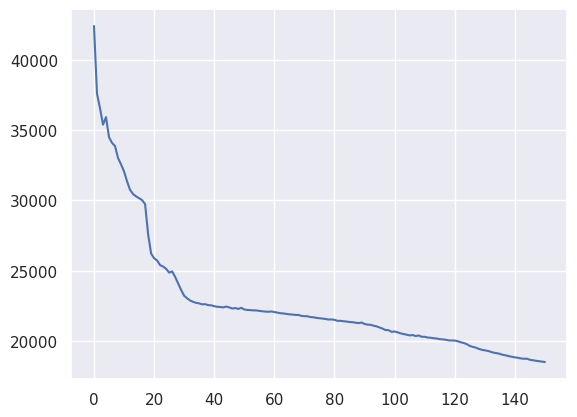

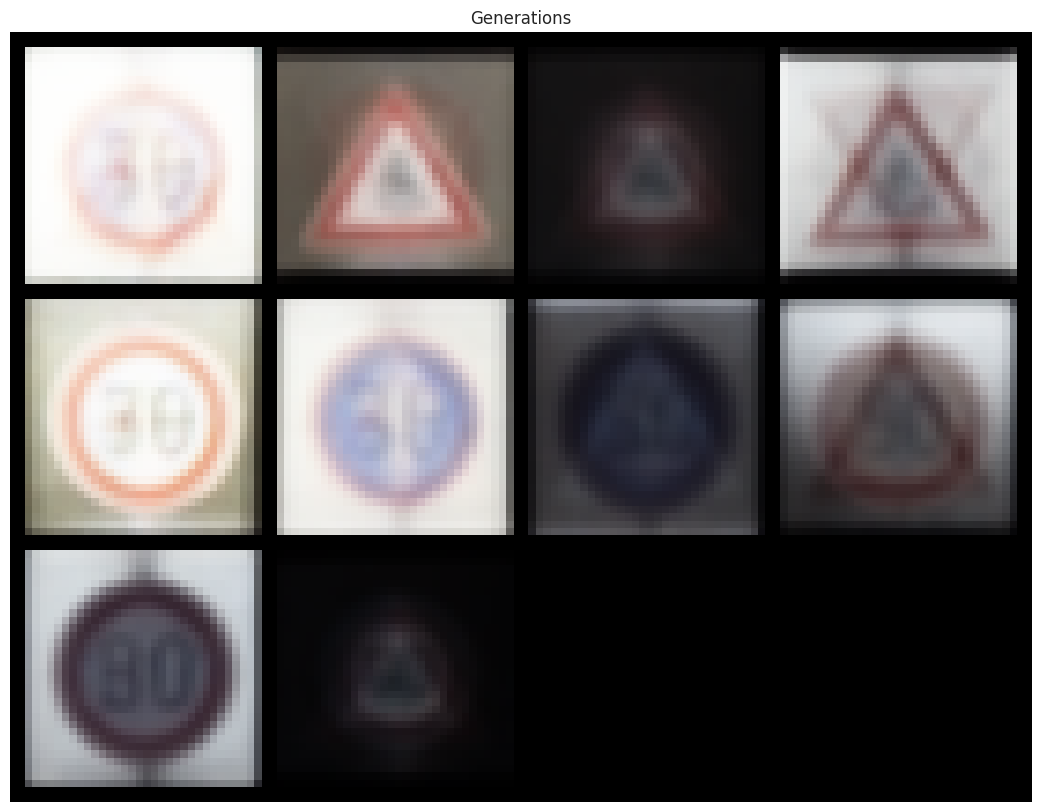

Epoch 151 loss 18469.573535794527
Epoch 152 loss 18459.209635416668
Epoch 153 loss 18402.563285079657
Epoch 154 loss 18368.008597579657
Epoch 155 loss 18354.834360957924
Epoch 156 loss 18317.516033496733
Epoch 157 loss 18281.91974954044
Epoch 158 loss 18259.56432546977
Epoch 159 loss 18241.108813316994
Epoch 160 loss 18203.710841758577
Epoch 161 loss 18188.282418045343
Epoch 162 loss 18190.01003370098
Epoch 163 loss 18148.908771190767
Epoch 164 loss 18114.12725949755
Epoch 165 loss 18104.028645833332
Epoch 166 loss 18083.119919321896
Epoch 167 loss 18078.01642284518
Epoch 168 loss 18052.412926368463
Epoch 169 loss 18037.55122166054
Epoch 170 loss 18017.134465635212
Epoch 171 loss 18005.86198554943
Epoch 172 loss 17981.31041283701
Epoch 173 loss 17972.787754033907
Epoch 174 loss 17961.90358838848
Epoch 175 loss 17927.369402318218
Epoch 176 loss 17919.11475566789
Epoch 177 loss 17926.220320159315
Epoch 178 loss 17902.046823937908
Epoch 179 loss 17892.26189108456
Epoch 180 loss 17872.4059

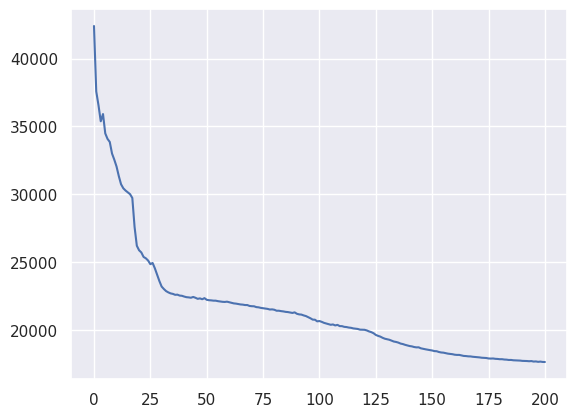

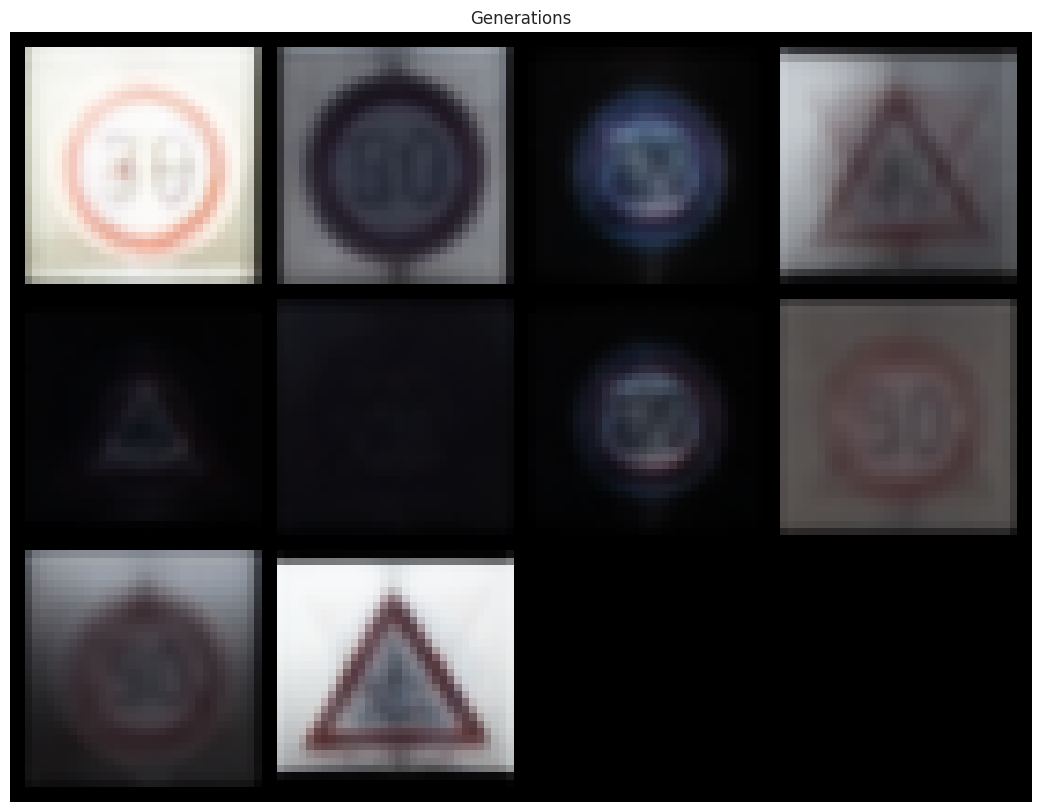

Epoch 201 loss 17664.395456750408
Epoch 202 loss 17657.76083154616
Epoch 203 loss 17644.043485753675
Epoch 204 loss 17638.823886846407
Epoch 205 loss 17637.49578737745
Epoch 206 loss 17616.269614225897
Epoch 207 loss 17623.92626633987
Epoch 208 loss 17602.574652777777
Epoch 209 loss 17598.75861672794
Epoch 210 loss 17602.211614072712
Epoch 211 loss 17603.991191789217
Epoch 212 loss 17585.94256152982
Epoch 213 loss 17582.10550704657
Epoch 214 loss 17564.60729421977
Epoch 215 loss 17564.5718188317
Epoch 216 loss 17562.919002757353
Epoch 217 loss 17553.32816967933
Epoch 218 loss 17553.773514093136
Epoch 219 loss 17541.47243923611
Epoch 220 loss 17519.686280892565
Epoch 221 loss 17523.864449295343
Epoch 222 loss 17512.02706929126
Epoch 223 loss 17505.189702052696
Epoch 224 loss 17495.98157935049
Epoch 225 loss 17500.418211294935
Epoch 226 loss 17501.827786713642
Epoch 227 loss 17495.660756229576
Epoch 228 loss 17497.611245149103
Epoch 229 loss 17482.624604268793
Epoch 230 loss 17467.809429

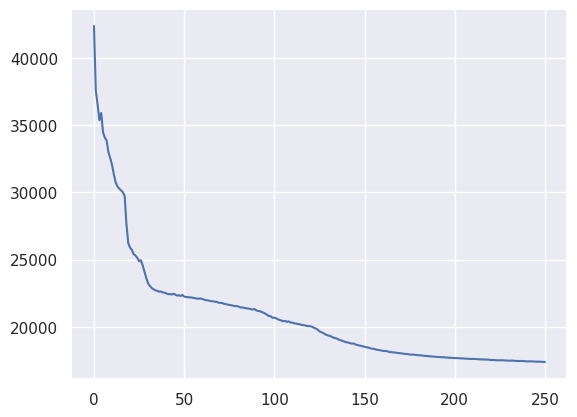

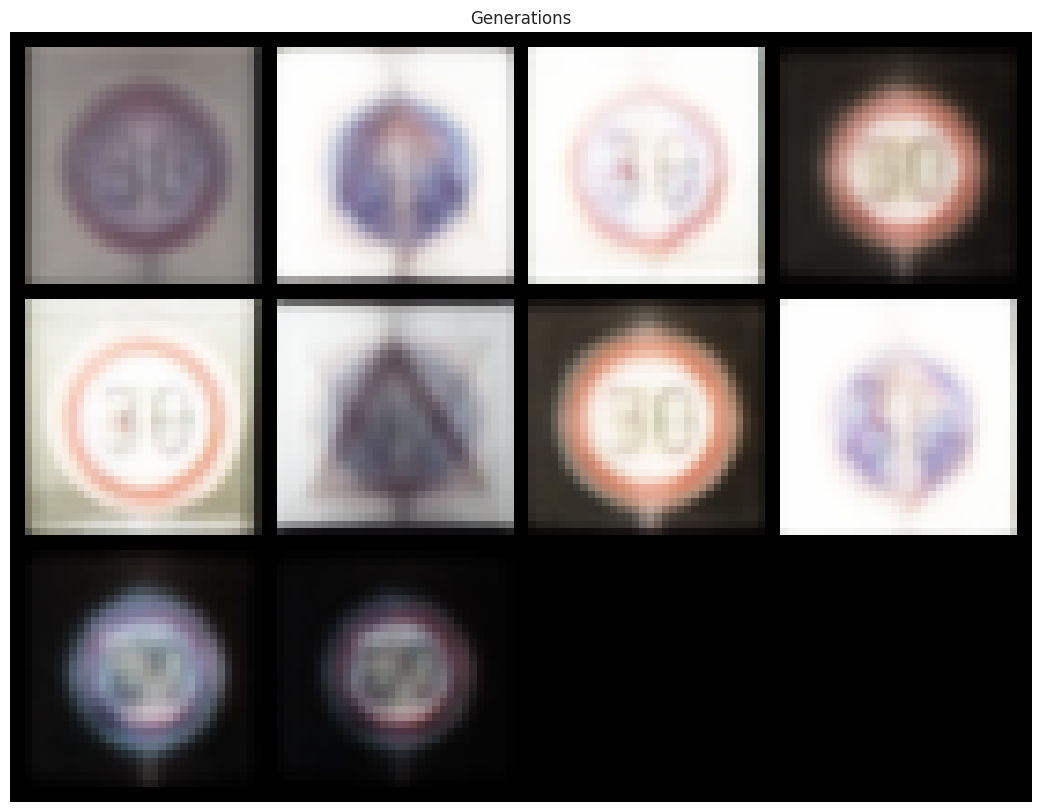

Epoch 251 loss 17381.303921568626
Epoch 252 loss 17379.66895169526
Epoch 253 loss 17370.987317453022
Epoch 254 loss 17371.86520246119
Epoch 255 loss 17376.140082465277
Epoch 256 loss 17363.06374463848
Epoch 257 loss 17346.40430325776
Epoch 258 loss 17345.168332567402
Epoch 259 loss 17334.436951082516
Epoch 260 loss 17351.809193729576
Epoch 261 loss 17342.1202831393
Epoch 262 loss 17336.598403033087
Epoch 263 loss 17337.052134395424
Epoch 264 loss 17334.824895322712
Epoch 265 loss 17327.16327103758
Epoch 266 loss 17313.7508106107
Epoch 267 loss 17314.934174581293
Epoch 268 loss 17310.197591145832
Epoch 269 loss 17314.246163960375
Epoch 270 loss 17311.15932649101
Epoch 271 loss 17311.155011744282
Epoch 272 loss 17313.67214307598
Epoch 273 loss 17307.68825316585
Epoch 274 loss 17307.431238511028
Epoch 275 loss 17290.341337316175
Epoch 276 loss 17283.34894556781
Epoch 277 loss 17289.620691636028
Epoch 278 loss 17286.623653237337
Epoch 279 loss 17288.640695210375
Epoch 280 loss 17290.100324

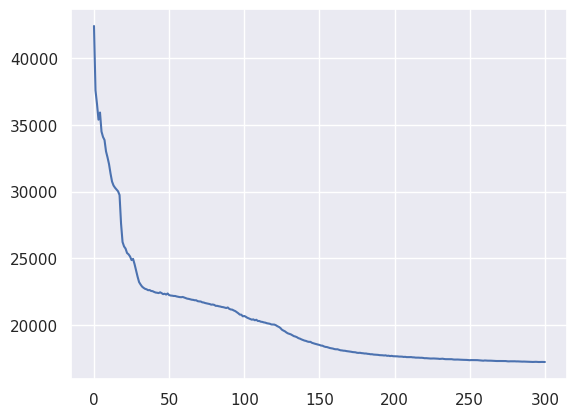

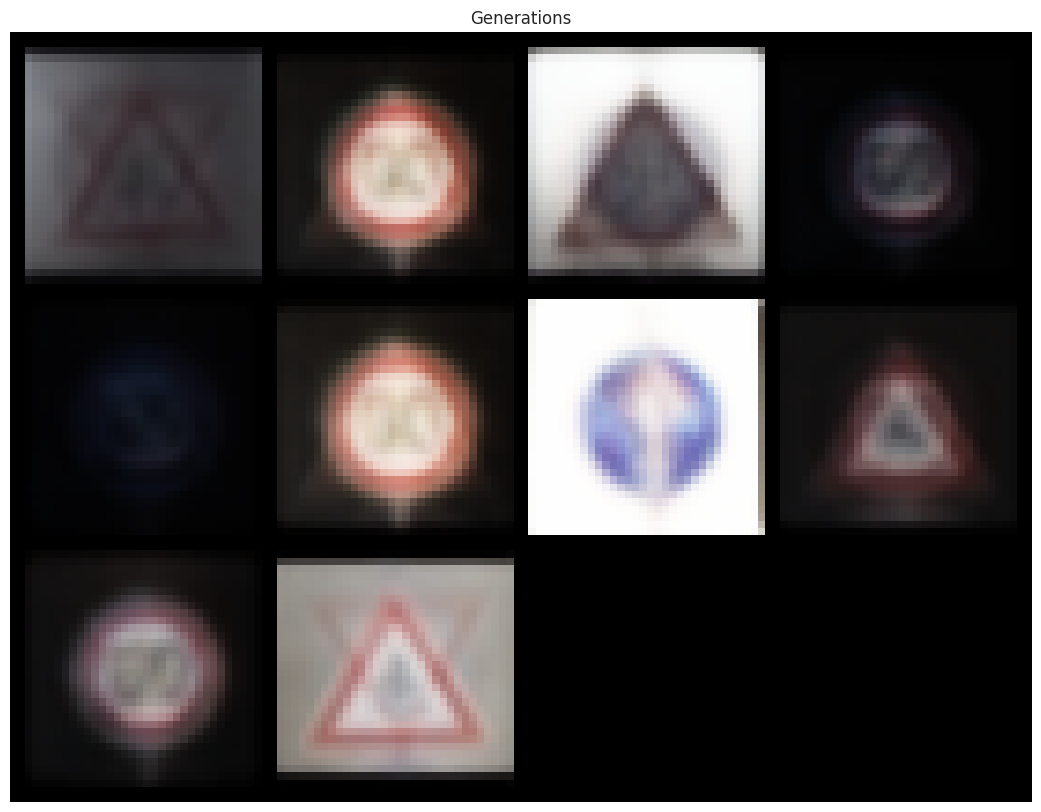

Epoch 301 loss 17229.894831239788
Epoch 302 loss 17223.46889042075
Epoch 303 loss 17209.809110753675
Epoch 304 loss 17229.66339869281
Epoch 305 loss 17223.237113204657
Epoch 306 loss 17210.143503625408
Epoch 307 loss 17211.517878114788
Epoch 308 loss 17208.065442453022
Epoch 309 loss 17213.419583588642
Epoch 310 loss 17214.375893586603
Epoch 311 loss 17214.875925500408
Epoch 312 loss 17206.576535692402
Epoch 313 loss 17193.708026960783
Epoch 314 loss 17197.224188112745
Epoch 315 loss 17199.436676623776
Epoch 316 loss 17189.639980341093
Epoch 317 loss 17186.886157066994
Epoch 318 loss 17194.563853145424
Epoch 319 loss 17195.726715686276
Epoch 320 loss 17186.430817248776
Epoch 321 loss 17193.59258833742
Epoch 322 loss 17179.00053615196
Epoch 323 loss 17179.416034773283
Epoch 324 loss 17178.8413500817
Epoch 325 loss 17182.631823171978
Epoch 326 loss 17181.103630514706
Epoch 327 loss 17172.400543811276
Epoch 328 loss 17163.99320874183
Epoch 329 loss 17181.254423253675
Epoch 330 loss 17170.

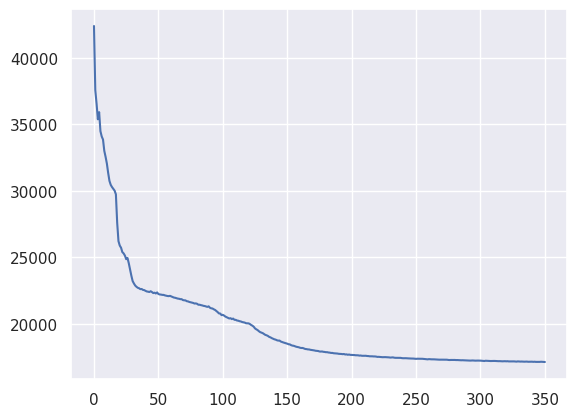

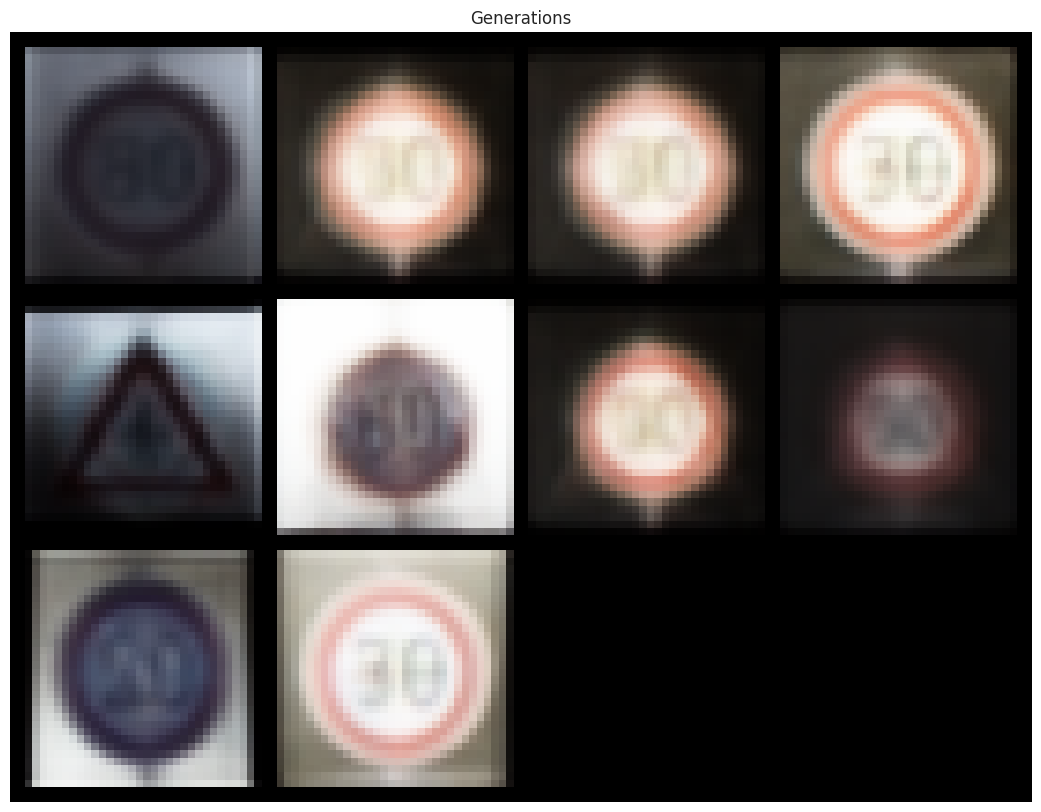

Epoch 351 loss 17126.588496987337
Epoch 352 loss 17134.398507710375
Epoch 353 loss 17123.407066993463
Epoch 354 loss 17124.12255540237
Epoch 355 loss 17128.684506484886
Epoch 356 loss 17120.426042943218
Epoch 357 loss 17126.830844056374
Epoch 358 loss 17132.150179993874
Epoch 359 loss 17124.666136897467
Epoch 360 loss 17124.583729064543
Epoch 361 loss 17119.77951388889
Epoch 362 loss 17124.880648743874
Epoch 363 loss 17119.912581699347
Epoch 364 loss 17118.78823274101
Epoch 365 loss 17122.397339665033
Epoch 366 loss 17113.40118847018
Epoch 367 loss 17108.72069674224
Epoch 368 loss 17111.327697354984
Epoch 369 loss 17113.656364889706
Epoch 370 loss 17112.164522058825
Epoch 371 loss 17119.43070235907
Epoch 372 loss 17115.160928564135
Epoch 373 loss 17118.563316993463
Epoch 374 loss 17112.025958690767
Epoch 375 loss 17100.252636080473
Epoch 376 loss 17111.0791015625
Epoch 377 loss 17097.799396190767
Epoch 378 loss 17101.678104575163
Epoch 379 loss 17107.679272620506
Epoch 380 loss 17095.9

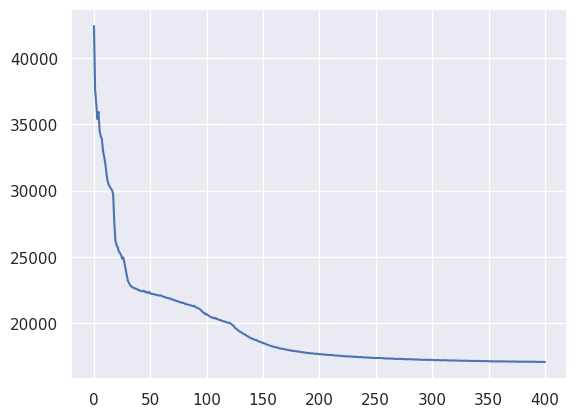

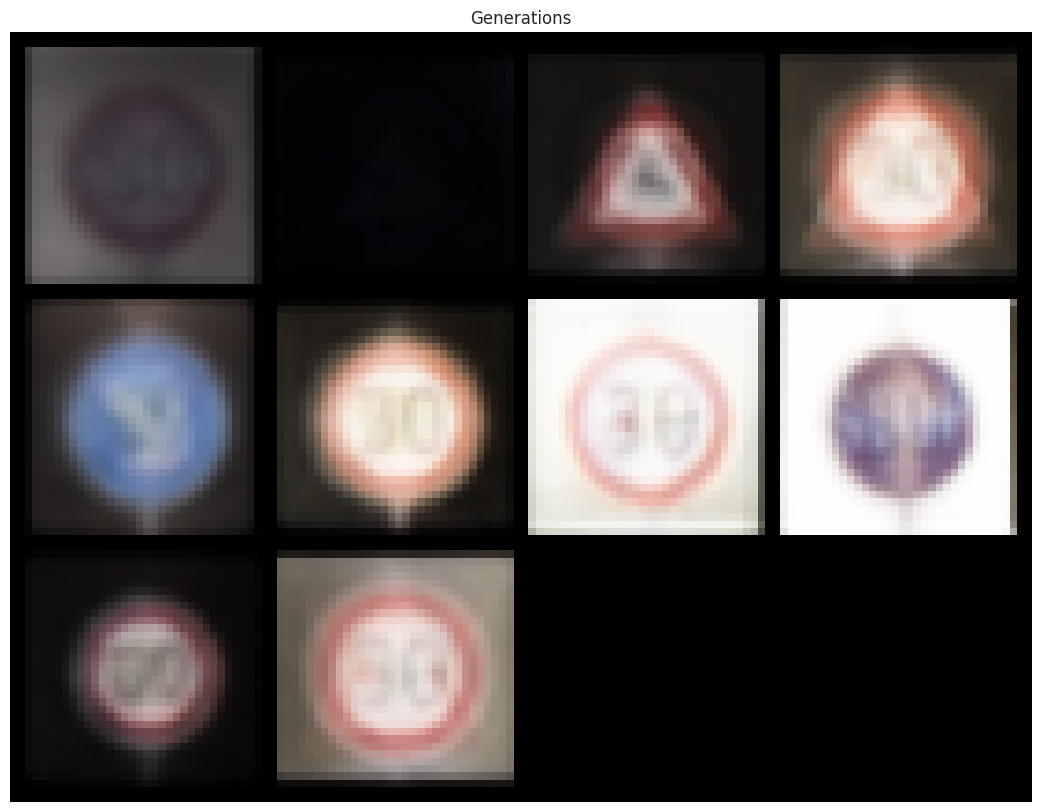

Epoch 401 loss 17085.992608762255
Epoch 402 loss 17079.3345141442
Epoch 403 loss 17066.423004748776
Epoch 404 loss 17077.17121119281
Epoch 405 loss 17083.766627093544
Epoch 406 loss 17071.027407577614
Epoch 407 loss 17078.49836601307
Epoch 408 loss 17081.07794628268
Epoch 409 loss 17082.573529411766
Epoch 410 loss 17074.968239379086
Epoch 411 loss 17069.338273590685
Epoch 412 loss 17074.687340430963
Epoch 413 loss 17074.608500561684
Epoch 414 loss 17074.415645424837
Epoch 415 loss 17075.827831392973
Epoch 416 loss 17065.698854932598
Epoch 417 loss 17078.044047436684
Epoch 418 loss 17067.78598600899
Epoch 419 loss 17059.383725234886
Epoch 420 loss 17064.377872242647
Epoch 421 loss 17062.950520833332
Epoch 422 loss 17071.21567989175
Epoch 423 loss 17063.526067197712
Epoch 424 loss 17056.17543019812
Epoch 425 loss 17067.049874897875
Epoch 426 loss 17059.651750153185
Epoch 427 loss 17057.87680632149
Epoch 428 loss 17050.359483506945
Epoch 429 loss 17066.26486545139
Epoch 430 loss 17060.706

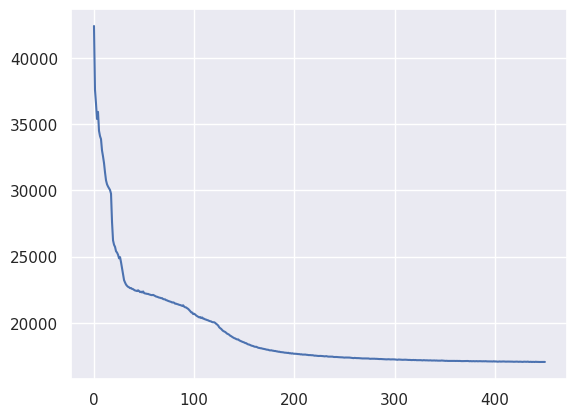

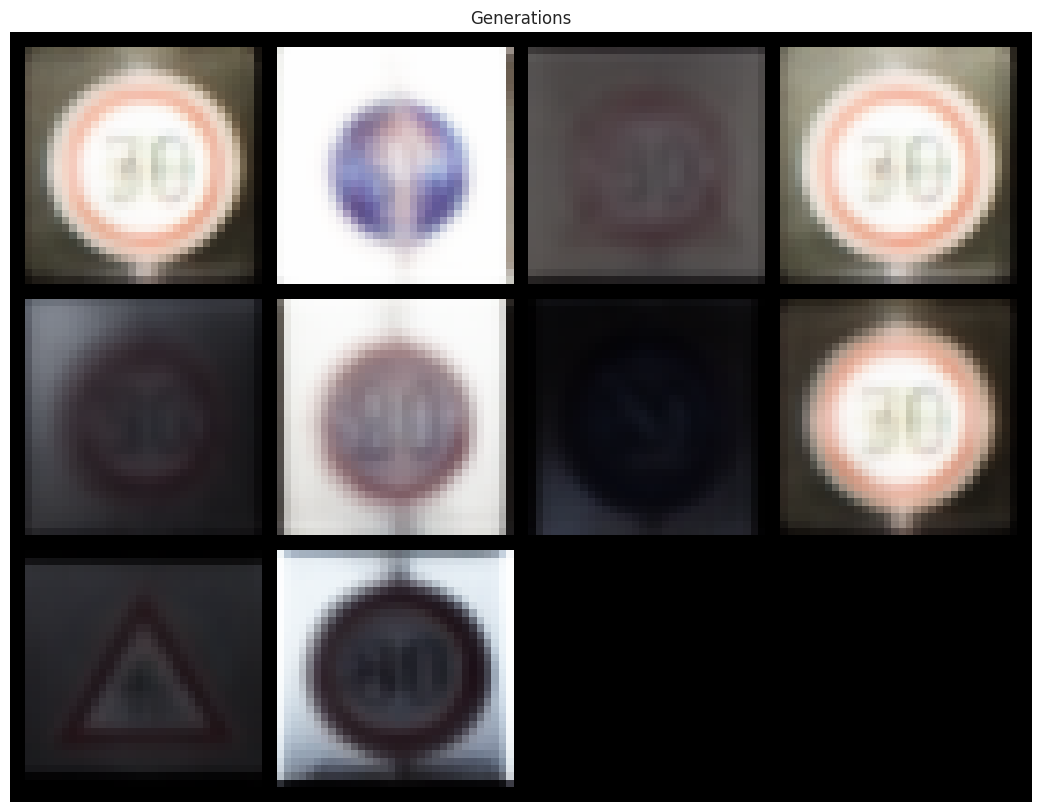

Epoch 451 loss 17052.456558925653
Epoch 452 loss 17061.078367544935
Epoch 453 loss 17039.341994740604
Epoch 454 loss 17055.45977583742
Epoch 455 loss 17033.642476000816
Epoch 456 loss 17040.82065716912
Epoch 457 loss 17046.350081699347
Epoch 458 loss 17046.508769914217
Epoch 459 loss 17043.570886948528
Epoch 460 loss 17039.678379033907
Epoch 461 loss 17034.143044066586
Epoch 462 loss 17044.457235498365
Epoch 463 loss 17032.220958435457
Epoch 464 loss 17030.11670879289
Epoch 465 loss 17030.86550245098
Epoch 466 loss 17033.598128574347
Epoch 467 loss 17038.30827461193
Epoch 468 loss 17037.55420241013
Epoch 469 loss 17042.586677900326
Epoch 470 loss 17031.243010876224
Epoch 471 loss 17049.525639552696
Epoch 472 loss 17026.623595792484
Epoch 473 loss 17035.769633374184
Epoch 474 loss 17031.766990910946
Epoch 475 loss 17041.505450878267
Epoch 476 loss 17031.437270220587
Epoch 477 loss 17027.075878267973
Epoch 478 loss 17027.848517922794
Epoch 479 loss 17039.119836345995
Epoch 480 loss 17040

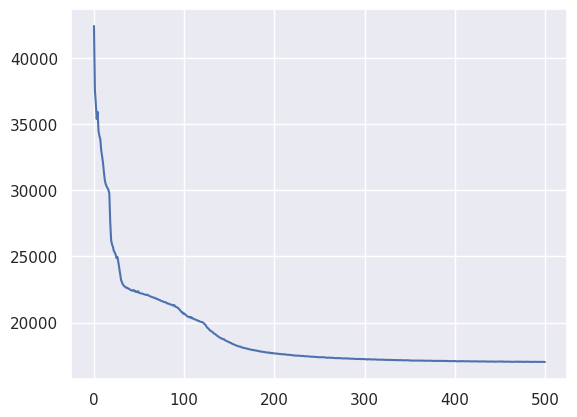

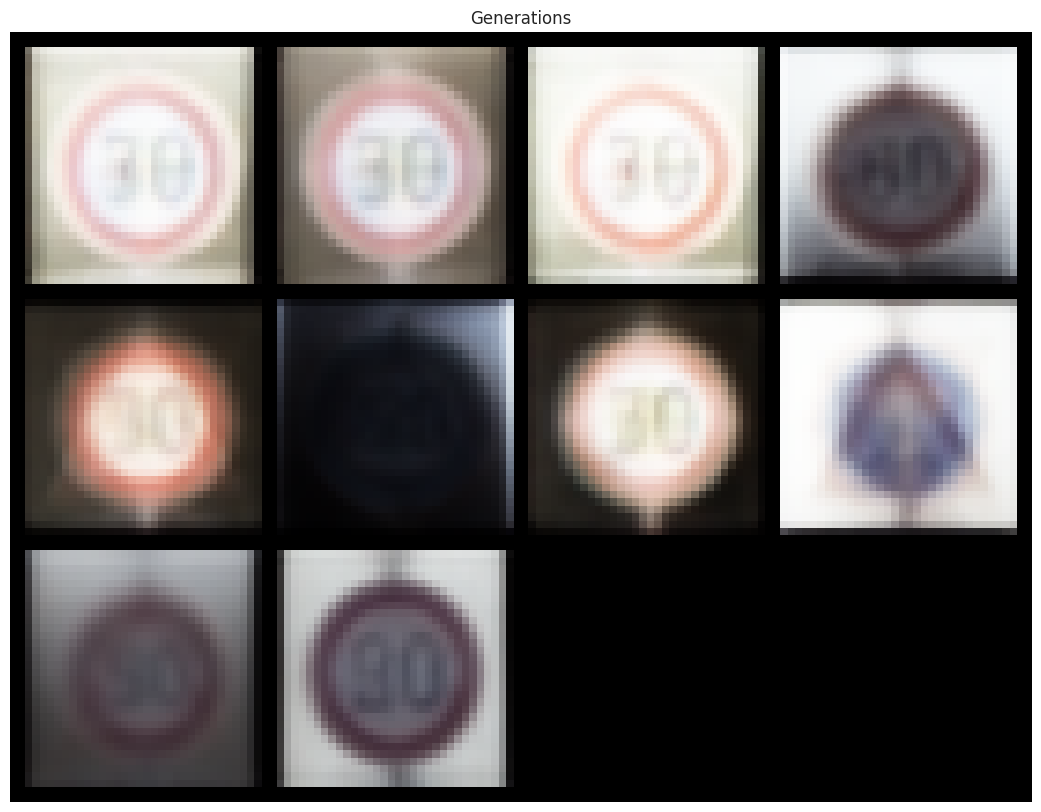

Epoch 501 loss 17019.571895424837
Epoch 502 loss 17021.44761029412
Epoch 503 loss 17023.110326031456
Epoch 504 loss 17027.91618795956
Epoch 505 loss 17022.537313623365
Epoch 506 loss 17021.75589767157
Epoch 507 loss 17026.84702435662
Epoch 508 loss 17009.598428564135
Epoch 509 loss 17024.55886820874
Epoch 510 loss 17020.943033854168
Epoch 511 loss 17015.755833843956
Epoch 512 loss 17012.321844362745
Epoch 513 loss 17026.420687806374
Epoch 514 loss 17020.714243770424
Epoch 515 loss 17007.788698682598
Epoch 516 loss 17012.157015931374
Epoch 517 loss 17019.143854677288
Epoch 518 loss 17017.866772620506
Epoch 519 loss 17014.393567453022
Epoch 520 loss 17012.791117749184
Epoch 521 loss 17021.370315053104
Epoch 522 loss 17005.175008935865
Epoch 523 loss 17011.31010646446
Epoch 524 loss 17012.700488919527
Epoch 525 loss 17015.266665390114
Epoch 526 loss 17016.25621680964
Epoch 527 loss 17007.81449142157
Epoch 528 loss 17011.509025224674
Epoch 529 loss 17015.798355800653
Epoch 530 loss 17012.8

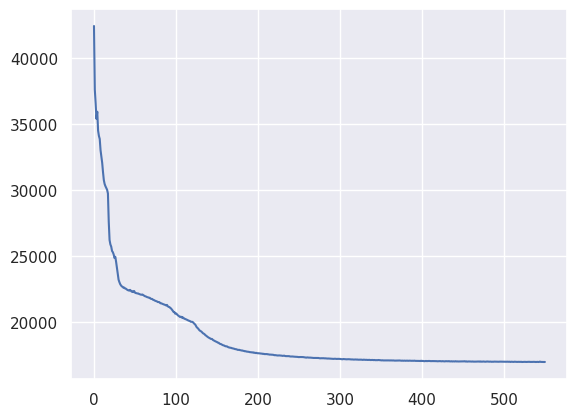

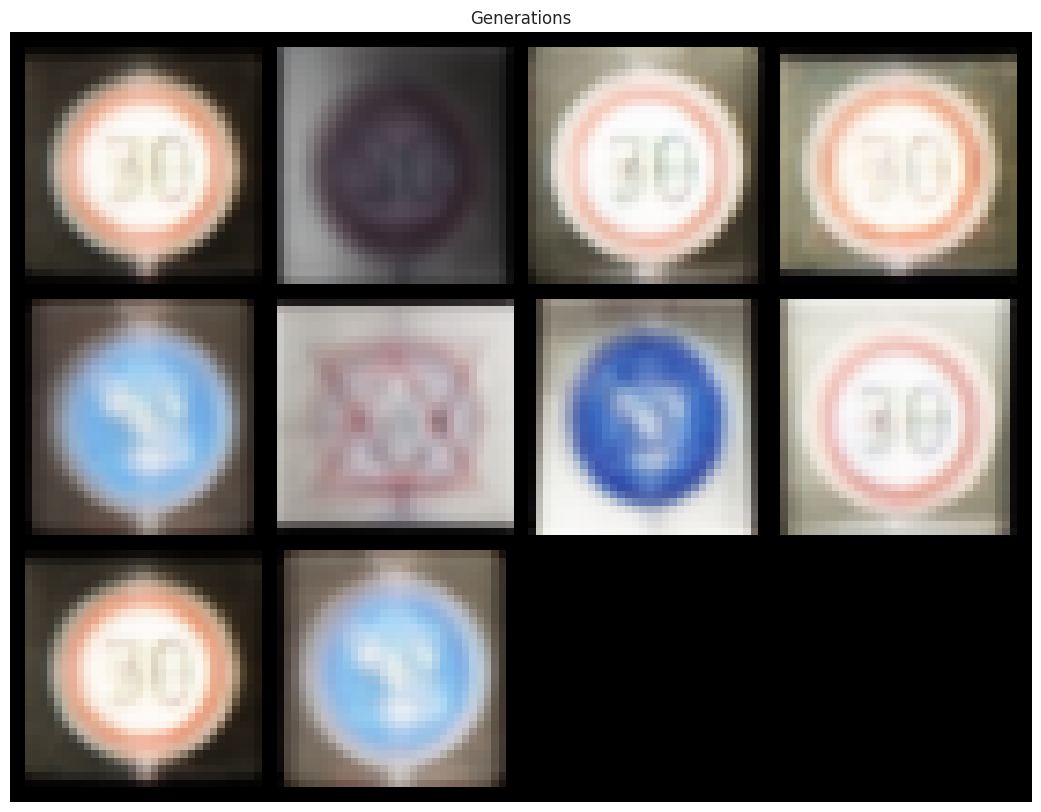

Epoch 551 loss 17000.585152420343
Epoch 552 loss 16999.50284032884
Epoch 553 loss 17011.21728834763
Epoch 554 loss 17002.620270373776
Epoch 555 loss 17000.755782781864
Epoch 556 loss 17006.562244689543
Epoch 557 loss 17002.846571180555
Epoch 558 loss 17007.06449780433
Epoch 559 loss 17007.971296721815
Epoch 560 loss 17008.347503063724
Epoch 561 loss 17006.33286739175
Epoch 562 loss 17019.062704248365
Epoch 563 loss 17008.689204197304
Epoch 564 loss 16996.571493310865
Epoch 565 loss 17016.534122242647
Epoch 566 loss 17012.503670087826
Epoch 567 loss 16993.31817427492
Epoch 568 loss 17006.476683772467
Epoch 569 loss 17013.351760365604
Epoch 570 loss 16994.1876659518
Epoch 571 loss 16997.635314542484
Epoch 572 loss 17011.458371629902
Epoch 573 loss 17014.33416947508
Epoch 574 loss 17004.95401220384
Epoch 575 loss 17008.524643841913
Epoch 576 loss 17002.86278977737
Epoch 577 loss 17006.790434793707
Epoch 578 loss 17011.721175449347
Epoch 579 loss 17012.469777624592
Epoch 580 loss 16994.789

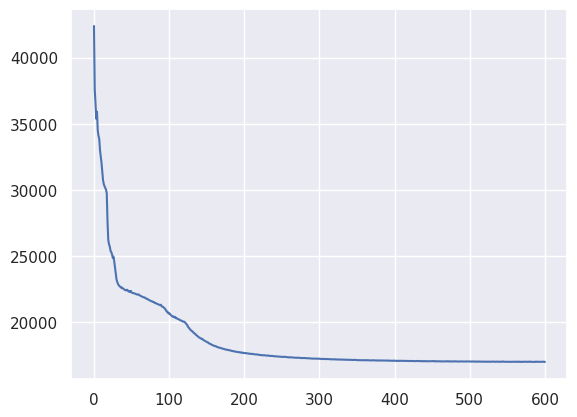

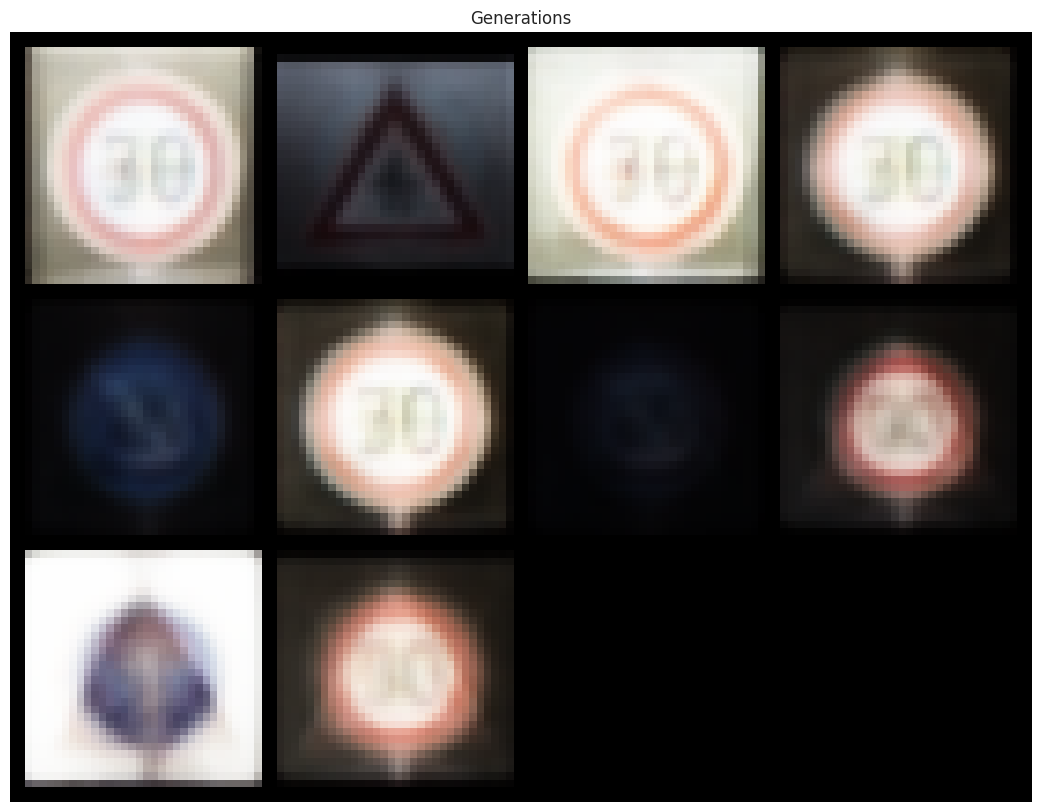

Epoch 601 loss 17001.812168096407
Epoch 602 loss 16993.116670496325
Epoch 603 loss 17007.898111979168
Epoch 604 loss 17000.40030126634
Epoch 605 loss 16995.388908037174
Epoch 606 loss 17009.89245046977
Epoch 607 loss 17003.971092473446
Epoch 608 loss 16990.180727890114
Epoch 609 loss 16990.69184666054
Epoch 610 loss 16996.342441533907
Epoch 611 loss 17001.30158547794
Epoch 612 loss 16996.553870506537
Epoch 613 loss 16996.704388786766
Epoch 614 loss 16998.76543989992
Epoch 615 loss 17004.492072610294
Epoch 616 loss 17000.41489225899
Epoch 617 loss 17008.925398284315
Epoch 618 loss 16992.5785717933
Epoch 619 loss 16996.632576337826
Epoch 620 loss 16994.13747829861
Epoch 621 loss 16993.03186912786
Epoch 622 loss 17001.684902216093
Epoch 623 loss 16993.481726154005
Epoch 624 loss 16992.502023335375
Epoch 625 loss 16999.18031939338
Epoch 626 loss 16997.77493744894
Epoch 627 loss 16993.359266493055
Epoch 628 loss 16983.451816533907
Epoch 629 loss 17003.94642948325
Epoch 630 loss 16998.938738

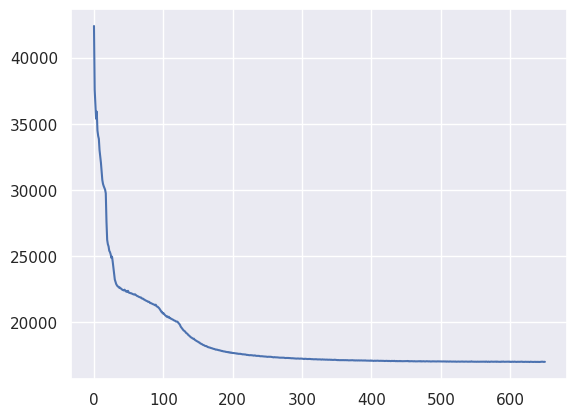

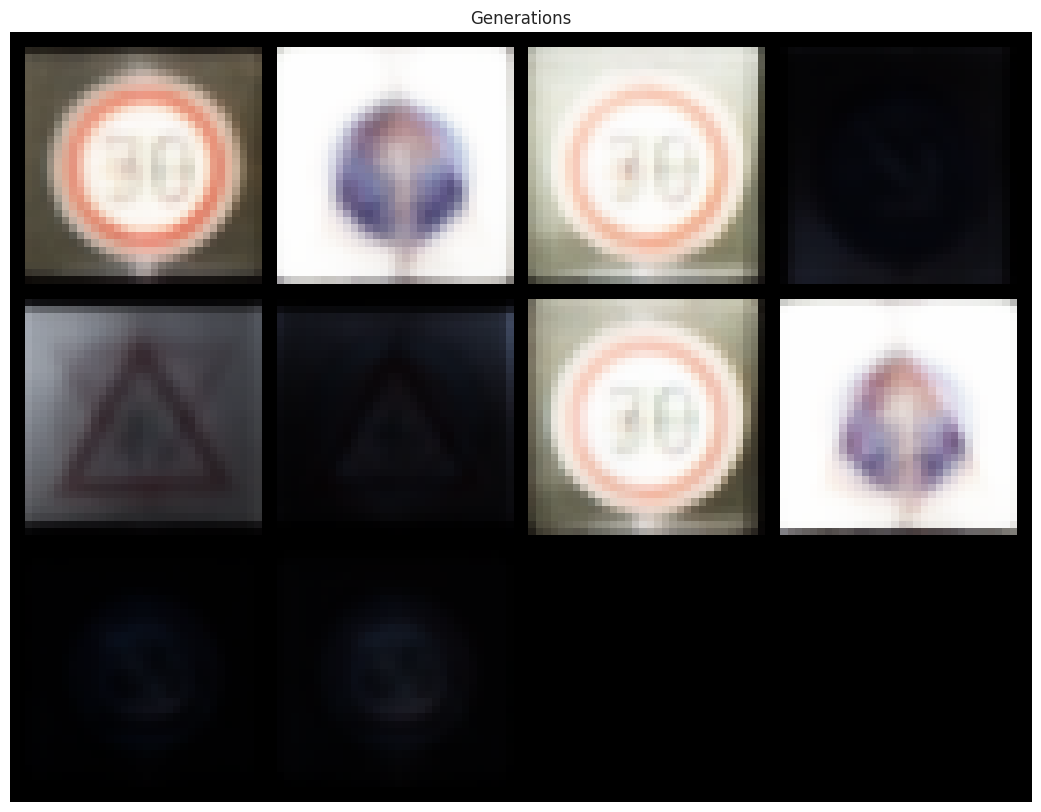

Epoch 651 loss 17000.65628829657
Epoch 652 loss 16991.76478885825
Epoch 653 loss 16993.78835401348
Epoch 654 loss 16996.84885620915
Epoch 655 loss 16994.536049836603
Epoch 656 loss 16994.96106515523
Epoch 657 loss 17005.15922436683
Epoch 658 loss 16997.845900990604
Epoch 659 loss 16986.811446844364
Epoch 660 loss 16993.001231872957
Epoch 661 loss 17003.42006867851
Epoch 662 loss 17004.458920547386
Epoch 663 loss 17006.133903952206
Epoch 664 loss 16994.29034543505
Epoch 665 loss 16986.908535028593
Epoch 666 loss 16988.095090379902
Epoch 667 loss 16996.571027369282
Epoch 668 loss 16992.015229268793
Epoch 669 loss 16995.503267973858
Epoch 670 loss 17000.719126582924
Epoch 671 loss 16983.19057010825
Epoch 672 loss 16999.149701286766
Epoch 673 loss 17008.127827563316
Epoch 674 loss 16988.149662990196
Epoch 675 loss 16985.70863332312
Epoch 676 loss 16985.266084558825
Epoch 677 loss 16992.615317350897
Epoch 678 loss 16997.57164011438
Epoch 679 loss 16989.5591235192
Epoch 680 loss 16986.166430

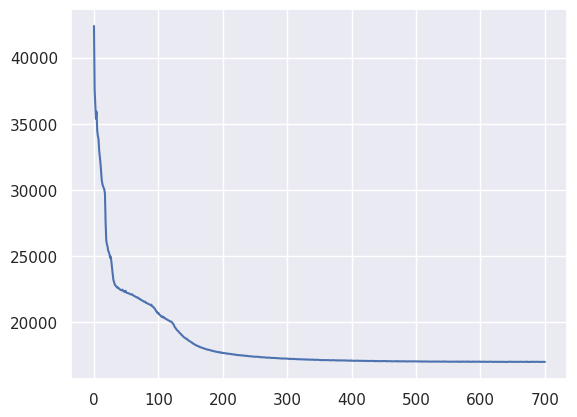

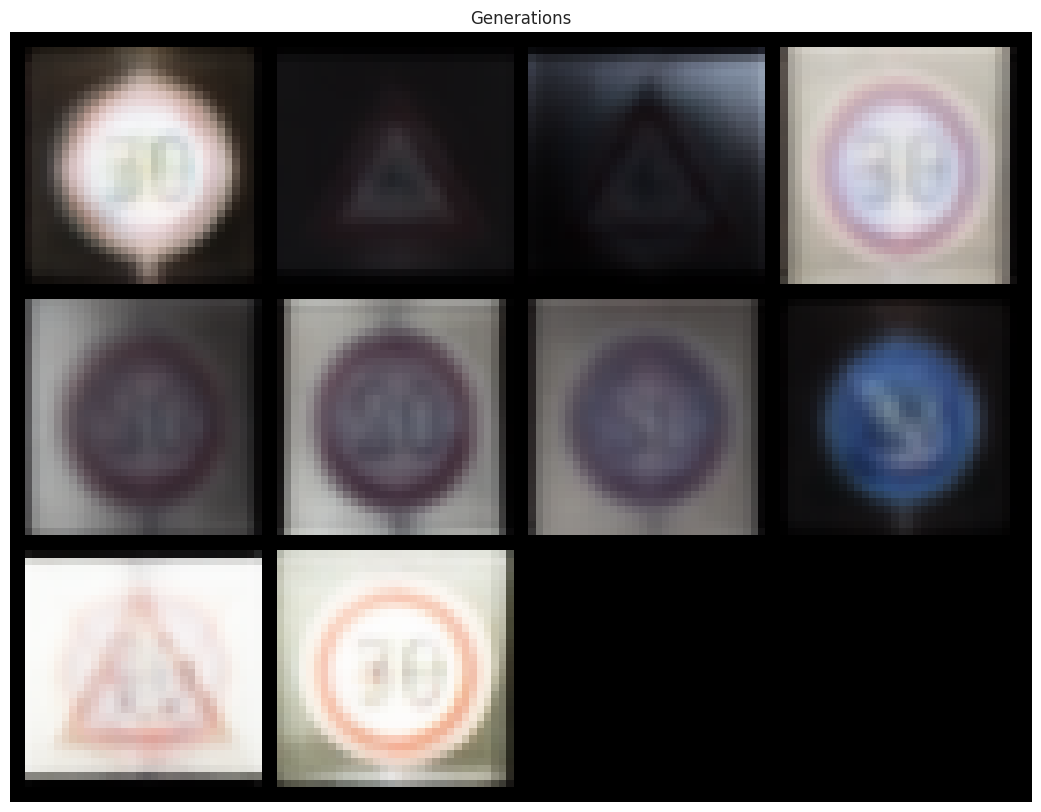

Epoch 701 loss 16994.844981872957
Epoch 702 loss 16989.856158088234
Epoch 703 loss 16996.523009854984
Epoch 704 loss 16992.844752093544
Epoch 705 loss 16989.93989353554


KeyboardInterrupt: 

In [18]:
epochs_losses = []
num_epochs = 15000
for n in range(num_epochs):
    losses_epoch = []
    for x, _ in iter(train_loader):
        x = x.to(device)

        classes_encoded = get_classes_encoded(train_classes, _, encoding).to(device)
        out, means, log_var = vae(x, classes_encoded)
        loss = vae_loss_function(x, out, means, log_var)
        losses_epoch.append(loss.item())
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    epochs_losses.append(np.mean(np.array(losses_epoch)))
    print(f"Epoch {n} loss {epochs_losses[-1]}")
    if n % 50 == 0:
        plt.plot(epochs_losses)
        generate_images(vae, 10, device)
    vae.train()
    scheduler.step()

In [19]:
def get_train_images(num):
    return torch.stack([train_data[i][0] for i in range(10,10+num)], dim=0)

In [20]:
input_imgs = get_train_images(8)

In [21]:
def generate_images(model, n_imgs, device):
    # Generate images
    model.eval()
    rmd_to_genrate = torch.randn([n_imgs, model.latent_dim])
    classes_to_generate = torch.concat((rmd_to_genrate, encoding[:n_imgs]), dim=1).to(device)
    with torch.no_grad():
        generated_imgs = model.decoder(classes_to_generate).to(device)
    generated_imgs = generated_imgs.cpu()


    grid = torchvision.utils.make_grid(generated_imgs, nrow=4)
    grid = grid.permute(1, 2, 0)
    if len(input_imgs) == 4:
        plt.figure(figsize=(10,10))
    else:
        plt.figure(figsize=(15,10))
    plt.title(f"Generations")
    plt.imshow(grid)
    plt.axis('off')
    plt.show()

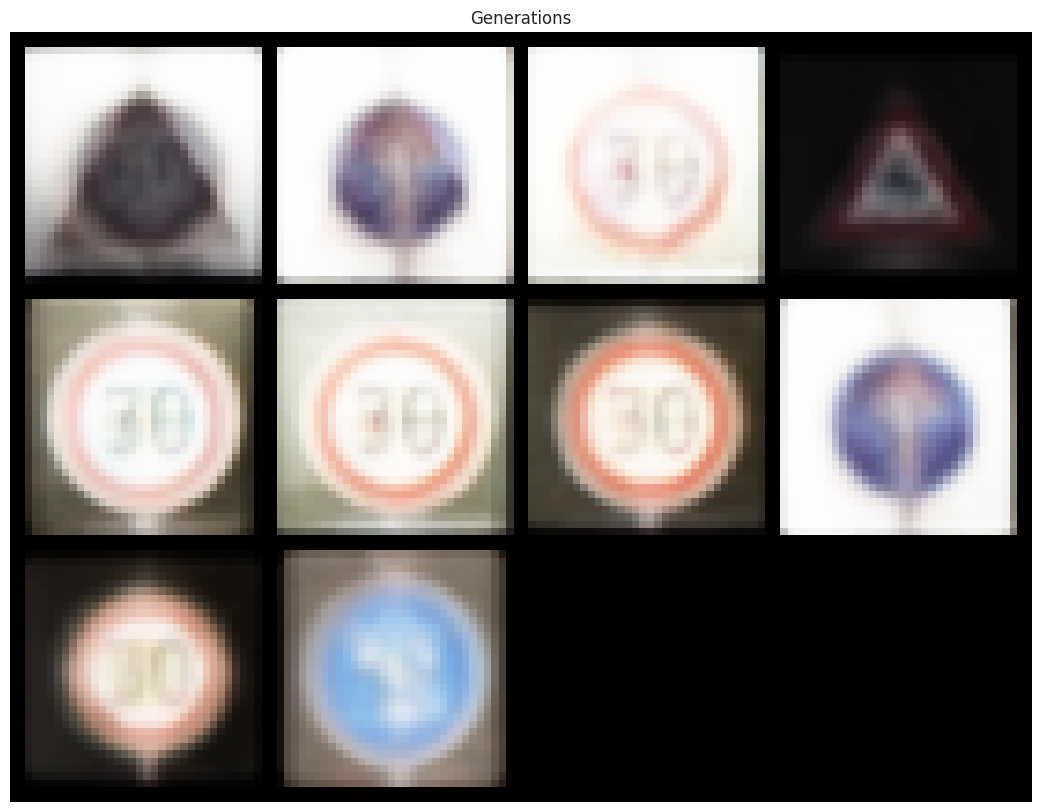

In [38]:
generate_images(vae, 10, device)

In [42]:
def im_save(img, path):
    save_image(img, path)

def evaluate_model(model, train_data, encoding: list, train_classes):
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=1000, shuffle=True, drop_last=True, pin_memory=True, num_workers=4)
    images, labels = next(iter(train_loader))
    rmd_to_genrate = torch.randn([1000, model.latent_dim])
    encoded_classes = get_classes_encoded(train_classes, labels, encoding)

    classes_to_generate = torch.concat((rmd_to_genrate, encoded_classes), dim=1).to(device)
    with torch.no_grad():
        generated_imgs = model.decoder(classes_to_generate).to(device)
    generated_imgs = generated_imgs.cpu()

    torch.save(generated_imgs.detach(), "piatek_Jakomulski_Podrazka.pt")
    # to check the size of tensor
    t = torch.load("piatek_Jakomulski_Podrazka.pt")
    print(t.size())
    
    for i, img in enumerate(generated_iorig_data_2 = [x[0] for x in list(test_set)[-1000:]]
orig_data_2 = torch.cat(orig_data_2)
with torch.no_grad():
    dist_orig_data_2 = evaluator.get_features(orig_data_2.to(device)).cpu()mgs):
        im_save(img, f'gen_eval/img{i}.jpg')
    images = images.cpu()
    for i, img in enumerate(images):
        im_save(img, f'real_eval/img{i}.jpg')
    paths = ['real_eval', 'gen_eval']
    # return fid_score.calculate_fid_given_paths(paths, batch_size=200, device='cpu', dims=2048)


In [43]:
evaluate_model(vae, train_data, encoding, train_classes)

torch.Size([1000, 3, 32, 32])
